In [46]:
# Import modules 
import os
import string
from utils import model_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from pickle import dump, load

# Decoder model imports
import numpy as np
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array, prod
from keras.callbacks import ModelCheckpoint

#plot curve
import matplotlib.pyplot as plt
%inline matplotlib

UsageError: Line magic function `%inline` not found.


In [47]:
# File split for train, test and validation
if not ((os.path.exists('train.pkl')) and (os.path.exists('valid.pkl')) and (os.path.exists('test.pkl'))):
    train_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.devImages.txt'
    test_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.trainImages.txt'
    valid_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.testImages.txt'
    paths = []
    for path in [train_path, valid_path, test_path]:
        with open(path, 'r') as fh:
            paths = paths + fh.readlines()
    sample_idx = np.random.choice(len(paths), size=int(len(paths)), replace=False)

    # Train Set 80% of the data
    train_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[:int(len(sample_idx)*.80)]]
    valid_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[int(len(sample_idx)*.80):int(len(sample_idx)*.90)]]
    test_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[int(len(sample_idx)*.90):]]
    dump(train_set, open('train.pkl', 'wb'))
    dump(valid_set, open('valid.pkl', 'wb'))
    dump(test_set, open('test.pkl', 'wb'))
else:
    train_set = load(open('train.pkl', 'rb'))
    valid_set = load(open('valid.pkl', 'rb')) 
    test_set = load(open('test.pkl', 'rb'))

In [48]:
def initiate_encoder(arch='capsnet'):
    """
        Description: Initiate the encoder 
        :arch: 'capsnet' or 'vgg'
    """
    if arch=='capsnet':
        encoder_model = model_utils.load_DeepCapsNet(input_shape=(64,64,3), n_class=10, routings=3, \
                        weights=r'weights\deep_caps_best_weights.h5')
    else:
        encoder_model = model_utils.load_VGG()
    return encoder_model

In [49]:
def extract_features(model, directory, arch, path):
    """
        Description: Function to extract features through the model
        :model: The model object
        :directory: Path of the directory of images
        :path: Path to save the file
    """
    features = dict()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print('Feature extraction started')
    for name in os.listdir(directory):
        image_path = directory + '/' + name
        target_size = (64,64) if arch=='capsnet' else (224,224)
        try:
            image = load_img(image_path, target_size=target_size)
        except:
            print('{} could not be opened. Skipping'.format(image_path))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Extract the features from the last layer
        if arch=='capsnet':
            feature = model.predict(image, verbose=0).reshape(-1, 10*32)
        else:
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        # Populate the dictionary
        features[image_id] = feature
    path = os.path.join(path, 'features_{}.pkl'.format(arch))
    dump(features, open(path, 'wb'))
    print('Features extracted and stored at {}'.format(path))
    return

In [50]:
img_dir = r'..\Flickr8k\Flicker8k_Dataset'
arch = 'vgg'
encoder_model = initiate_encoder(arch=arch)
if not os.path.exists('features_{}.pkl'.format(arch)):
    extract_features(encoder_model, img_dir, arch, r'..\Flickr8k\Flickr8k_image_captioning_using_CapsNet')

Complete Capsule Architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 12

In [51]:
def read_files(filename):
    """
        Description: Generic function to read files and return contents
        :filename: Path of the files
    """
    with open(filename, 'r') as fh:
        content = fh.readlines()
    return ''.join(content)

In [52]:
# Load and clean descriptions of the images
def map_descriptions(desc_content):
    """
        Description: Map the descriptions <image>:[description_list]
        :desc_content: File content
    """
    # Each image contains 5 descriptions in the format
    # <image_name>#<1-5> sentence
    mapping = dict()
    lines = list()
    for line in desc_content.split('\n'):
        if len(line) < 2:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], ' '.join(tokens[1:])
        image_id = image_id.split('.')[0]
        table = str.maketrans('', '', string.punctuation)
        image_desc = image_desc.split()
        image_desc = [word.lower() for word in image_desc]
        image_desc = [w.translate(table) for w in image_desc]
        image_desc = [word for word in image_desc if (len(word)>1 and word.isalpha())]
        if image_id not in mapping:
            mapping[image_id] = list()
        # Append the list of the dictionary
        clean_desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        mapping[image_id].append(clean_desc)
        lines.append(image_id+' '+clean_desc)
    # Write the files to a clean description file
    with open('descriptions.txt', 'w') as fh:
        fh.writelines('\n'.join(lines))
    return mapping

def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [53]:
filename = r'..\Flickr8k\Flickr8k_text\Flickr8k.token.txt'
doc = read_files(filename)
descriptions = map_descriptions(doc)
print('Total Desciptions: %d ' % len(descriptions))
vocabulary = to_vocabulary(descriptions)
print('Total Vocabulary: %d' % len(vocabulary))

Total Desciptions: 8092 
Total Vocabulary: 8765


### Preparaing Training Set
* The dataset contains multiple files inside Flickr8k_text. The 8000 images are divided into:
    * Training Set: 6000
    * Validation Set: 1000
    * Test Set: 1000
* The images names for the training names are stored in the Flickr_8k.trainImages.txt.

In [54]:
print("Size of Training dataset: {}".format(len(set(train_set))))

Size of Training dataset: 6400


In [55]:
def create_tokenizer(descriptions):
    """
    Description: Tokenize the description
    """
    all_desc = list()
    for _, desc in descriptions.items():
        [all_desc.append(d) for d in desc]
    tokenizer = Tokenizer()
    max_length = max([len(desc.split()) for desc in all_desc])
    tokenizer.fit_on_texts(all_desc)
    dump(tokenizer, open('tokenizer.pkl', 'wb'))
    return tokenizer, max_length

In [56]:
# Load the training descriptions
train_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in train_set}
# Tokenize the the train description
train_tokenizer, max_length = create_tokenizer(train_desc)
# Get the features of training dataset
feature_path = "features_{}.pkl".format(arch)
# feature_path = "features_VGG.pkl"
all_features = load(open(feature_path, 'rb'))
train_features = {image_id:feat for image_id, feat in all_features.items() if image_id in train_set}

In [57]:
vocab_size = len(train_tokenizer.word_index) + 1
print('Vocabulary Size: {}\nMaximum Legth: {}\nloaded photo features: {}'\
      .format(vocab_size, max_length, len(train_features)))

Vocabulary Size: 7864
Maximum Legth: 34
loaded photo features: 6400


In [58]:
valid_features = {image_id:feat for image_id, feat in all_features.items() if image_id in valid_set}
valid_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in valid_set}

In [59]:
def define_model(encoder_shape, vocab_size, max_length):
    """
    Description: Define the decoder model
    :encoder_shape: Input from the image feature
    :vocab_size: 
    :max_length: maximum length of the description
    """
    inputs1 = Input(shape=(encoder_shape,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    return model

In [60]:
encoder_op_shape = prod(list(filter(None, encoder_model.layers[-1].output.shape.as_list())))
model = define_model(encoder_op_shape, vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      2013184     input_13[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_12[0][0]                   
__________________________________________________________________________________________________
dropout_4 

In [61]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    """
    Description: Create seqences for input <photo>, <description>, <output>
    """
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

In [62]:
# Train model for CNN model
epochs = 10
train_steps = len(train_desc)
val_steps = len(valid_desc)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}_VGG.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    # create the data generator
train_generator = data_generator(train_desc, train_features, train_tokenizer, max_length, vocab_size)
valid_generator = data_generator(valid_desc, valid_features, train_tokenizer, max_length, vocab_size)
    # fit for one epoch
history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=train_steps, verbose=1, validation_data=valid_generator,\
                    validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/10
6400/6400 [==============================] - 651s 102ms/step - loss: 4.6375 - val_loss: 4.0898

Epoch 00001: val_loss improved from inf to 4.08976, saving model to model-ep001-loss4.658-val_loss4.090_VGG.h5
Epoch 2/10
6400/6400 [==============================] - 636s 99ms/step - loss: 3.8758 - val_loss: 3.8771

Epoch 00002: val_loss improved from 4.08976 to 3.87713, saving model to model-ep002-loss3.896-val_loss3.877_VGG.h5
Epoch 3/10
6400/6400 [==============================] - 642s 100ms/step - loss: 3.6245 - val_loss: 3.8236

Epoch 00003: val_loss improved from 3.87713 to 3.82357, saving model to model-ep003-loss3.645-val_loss3.824_VGG.h5
Epoch 4/10
6400/6400 [==============================] - 649s 101ms/step - loss: 3.4826 - val_loss: 3.7976

Epoch 00004: val_loss improved from 3.82357 to 3.79762, saving model to model-ep004-loss3.504-val_loss3.798_VGG.h5
Epoch 5/10
6400/6400 [==============================] - 538s 84ms/step - loss: 3.3954 - val_loss: 3.8033

Epoch 00005

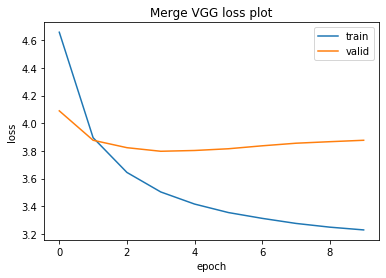

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Merge VGG loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [35]:
# Train model for CapsNet
epochs = 10
train_steps = len(train_desc)
val_steps = len(valid_desc)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}_CapsNet.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    # create the data generator
train_generator = data_generator(train_desc, train_features, train_tokenizer, max_length, vocab_size)
valid_generator = data_generator(valid_desc, valid_features, train_tokenizer, max_length, vocab_size)
    # fit for one epoch
history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=train_steps, verbose=1, validation_data=valid_generator,\
                    validation_steps=val_steps, callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
6400/6400 [==============================] - 475s 74ms/step - loss: 4.5856 - val_loss: 4.0623

Epoch 00001: val_loss improved from inf to 4.06230, saving model to model-ep001-loss4.601-val_loss4.062_CapsNet.h5
Epoch 2/10
6400/6400 [==============================] - 444s 69ms/step - loss: 3.8331 - val_loss: 3.8919

Epoch 00002: val_loss improved from 4.06230 to 3.89191, saving model to model-ep002-loss3.846-val_loss3.892_CapsNet.h5
Epoch 3/10
6400/6400 [==============================] - 440s 69ms/step - loss: 3.5745 - val_loss: 3.8607

Epoch 00003: val_loss improved from 3.89191 to 3.86071, saving model to model-ep003-loss3.588-val_loss3.861_CapsNet.h5
Epoch 4/10
6400/6400 [==============================] - 437s 68ms/step - loss: 3.4112 - val_loss: 3.8501

Epoch 00004: val_loss improved from 3.86071 to 3.85007, saving model to model-ep004-loss3.425-val_loss3.850_CapsNet.h5
Epoch 5/10
6400/6400 [==============================] - 

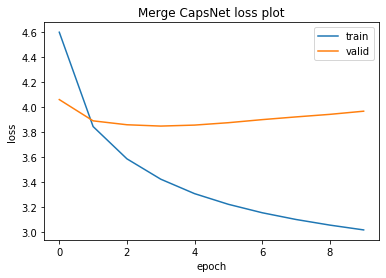

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Merge CapsNet loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Validation using BLEU score

In [64]:
# Import statement to instantiate the models
from utils import model_utils
# Import statements for other calculations
from pickle import load
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from numpy import array
from math import log

In [65]:
def generate_desc_beam_search(model, tokenizer, photo, max_length, beam_length=1):
    """
    Description: This function can be used to create description
    :model: The decoder model object
    :tokenizer: The tokenizer object used to get the words from predicted indexes
    :max_length: The maximum length of the sentence to be generated
    :beam_length: Length to check conditional probability. 
                1: for greedy search
                1+: For beam search
    """
    in_text = 'startseq'
    beam_list = list()
    for i in range(max_length):
        if not beam_list:
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo,sequence], verbose=0).squeeze()
            yhat_idx = yhat.argsort()[-beam_length:]
            for idx in yhat_idx:
                word = tokenizer.index_word[idx]
                in_text += ' ' + word
                beam_list.append((in_text, log(yhat[idx])))
        else:
            combination_list = list()
            for elems in beam_list:
                if elems[0].endswith('endseq'):
                    combination_list.append(elems)
                    continue
                in_text = elems[0]
                sequence = tokenizer.texts_to_sequences([in_text])[0]
                sequence = pad_sequences([sequence], maxlen=max_length)
                yhat = model.predict([photo,sequence], verbose=0).squeeze()
                yhat_idx = yhat.argsort()[-beam_length:]
                for idx in yhat_idx:
                    word = tokenizer.index_word[idx]
                    if word is None:
                        continue
                    in_text += ' ' + word
                    combination_list.append((in_text, elems[1]*log(yhat[idx])))
            probs = array([combinations[1] for combinations in combination_list])
            top_idx = probs.argsort()[-beam_length:]
            for i, idx in enumerate(top_idx):
                beam_list[i] = combination_list[idx]
    probs = array([prob[1] for prob in beam_list])
    top_idx = argmax(probs)        
    return beam_list[top_idx][0]

In [66]:
def get_BLEU(model, test_desc, photo_feature, tokenizer, max_length, beam_length=1):
    """
    Decription: This function can be used to evaluate BLEU score of the model word by word
    :model: The Decoder model
    :test_desc: test description
    :photo_feature: Extracted features of photos
    :tokenizer: Tokenizer object
    :max_length: Maximum length of the expected sentence
    :beam_length: Beam Length for beam search
    """
    actual, predicted = list(), list()
    count = 0
    for key, desc_list in test_desc.items():
        yhat = generate_desc_beam_search(model, tokenizer, photo_feature[key], max_length, beam_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### BLEU Score on the extracted features by VGG16

In [67]:
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
features = 'features_vgg.pkl'
all_features = load(open(features, 'rb'))
test_features = {image_id:feat for image_id, feat in all_features.items() if image_id in test_set}
test_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in test_set}

In [69]:
### Get the BLEU score VGG extracted features with beam length 1
vgg_decoder_path = "model-ep004-loss3.504-val_loss3.798_VGG.h5"
test_model = load_model(vgg_decoder_path)
beam_length = 1
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.540652
BLEU-2: 0.297865
BLEU-3: 0.203725
BLEU-4: 0.094188


In [70]:
# Beam length 2
beam_length = 2
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.269442
BLEU-2: 0.097745
BLEU-3: 0.041995
BLEU-4: 0.009466


### BLEU Score on the extracted features by Capsule Network

In [41]:
features = 'features_capsnet.pkl'
all_features = load(open(features, 'rb'))
tokenizer = load(open('tokenizer.pkl', 'rb'))
test_features = {image_id:feat for image_id, feat in all_features.items() if image_id in test_set}
test_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in test_set}
capsnet_decoder_path = "model-ep004-loss3.425-val_loss3.850_CapsNet.h5"
beam_length = 1
test_model = load_model(capsnet_decoder_path)
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.496194
BLEU-2: 0.236004
BLEU-3: 0.156967
BLEU-4: 0.073708


In [42]:
# Beam length 2
beam_length = 2
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.328121
BLEU-2: 0.106384
BLEU-3: 0.033642
BLEU-4: 0.000000


### Inference

In [43]:
def extract_feature(model, arch, image_path):
    """
    Description: Extract features for a given image
    :model: The Encoder model
    :arch: The arch type
    :image_path: Path to the image
    """
    feature = None
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    target_size = (64,64) if arch=='capsnet' else (224,224)
    try:
        image = load_img(image_path, target_size=target_size)
    except Exception as e:
        print('{} could not be opened. Skipping\n {}'.format(image_path,e))
        return None
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    if arch=='capsnet':
        feature = model.predict(image, verbose=0).reshape(-1, 10*32)
    else:
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
    return feature

In [71]:
arch = 'vgg'
encoder_model = initiate_encoder(arch)
# Extract features of the image
image_path = r'D:\CapsuleNetwork_ImageCaptioning\Test_image\2567035103_3511020c8f.jpg'
photo_feature = extract_feature(encoder_model, arch, image_path)
max_length = 34
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
# Load the decoder model
decoder_path = r"model-ep004-loss3.504-val_loss3.798_VGG.h5"
test_model = load_model(decoder_path)
# Beam Search length
beam_length = 1
print(generate_desc_beam_search(test_model, tokenizer, photo_feature, max_length, beam_length))

Complete Capsule Architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 12